# Feature Importances

- 특성 중요도 계산 방법들(**permutation importances**, Feature importance, ...)을 이해하고 사용하여 모델을 해석하고 특성 선택시 활용할 수 있다.
- **gradient boosting** 을 이해하고 xgboost를 사용하여 모델을 만들 수 있다.

- 배깅 복습
    - [Bootstrap aggregating bagging](https://youtu.be/2Mg8QD0F1dQ)
- 부스팅(Boosting)
    - [AdaBoost](https://youtu.be/LsK-xG1cLYA)
        - AdaBoost와 RandomForest와 핵심 차이점 3가지는? 
    - [Gradient Boosting](https://youtu.be/3CC4N4z3GJc)

- [**eli5**](https://eli5.readthedocs.io/en/latest/)
- [**xgboost**](https://xgboost.readthedocs.io/en/latest/)

#### H1N1 데이터를 다시 사용하여 학습을 진행하도록 하겠습니다.

In [21]:
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 KB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107747 sha256=6c9a00e40187c356573cb2dc1f995bc6d0b1ba814990b65c2eb79da92c1eb586
  Stored in directory: /root/.cache/pip/wheels/7b/26/a5/8460416695a992a2966b41caa5338e5e7fcea98c9d032d055c
Successfully built eli5


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# 타겟을 정합니다.
target = 'vacc_seas_f'
# 학습데이터 features, labels 를 병합합니다.
train = pd.merge(pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train.csv'), 
                 pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train_labels.csv')[target], left_index=True, right_index=True)
test = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/test.csv')



# 80/20 비율로 학습/테스트 데이터를 분리합니다.
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train[target], random_state=2)

def engineer(df):
    """특성을 엔지니어링 하는 함수입니다."""
    
    # 새로운 특성을 생성합니다.
    behaviorals = [col for col in df.columns if 'behavioral' in col] 
    df['behaviorals'] = df[behaviorals].sum(axis=1)
    
    dels = [col for col in df.columns if ('employment' in col or 'h1n1' in col)]
    df.drop(columns=dels, inplace=True)
        
    return df

train = engineer(train)
val = engineer(val)
test = engineer(test)

In [2]:
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

In [3]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 3.8 MB/s eta 0:00:00


In [4]:
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=100, random_state=2, n_jobs=-1)
)

In [5]:
pipe

Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                ('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2))])

In [6]:
from sklearn.metrics import classification_report
# train 학습, 검증셋 정확도
pipe.fit(X_train, y_train)
print('검증 정확도', pipe.score(X_val, y_val))

print(classification_report(y_val, pipe.predict(X_val)))


검증 정확도 0.7526983750444787
              precision    recall  f1-score   support

           0       0.76      0.80      0.78      4608
           1       0.74      0.70      0.72      3823

    accuracy                           0.75      8431
   macro avg       0.75      0.75      0.75      8431
weighted avg       0.75      0.75      0.75      8431



## 모델 해석과 특성 선택을 위한 순열 중요도(Permutation Importances) 계산

- 기본 특성 중요도는 빠르지만 특성 종류에 따라 부정확한 결과가 나올 수 있어 주의가 필요합니다.
- 순열 중요도 사용하면 더욱 정확한 계산이 가능합니다.

### 3가지 특성 중요도 계산 방법을 살펴 보겠습니다.

### 1. Feature Importances(Mean decrease impurity, MDI)
sklearn 트리 기반 분류기에서 디폴트로 사용되는 특성 중요도는 속도는 빠르지만 결과를 주의해서 봐야 합니다. 각각 특성을 모든 트리에 대해 평균불순도감소(mean decrease impurity)를 계산한 값입니다.

- [Sklearn, DecisionTreeClassifier, min_impurity_decrease](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn-tree-decisiontreeclassifier)

> 불순도 감소(impurity decrease)는 다음과 같이 계산합니다:

> $\displaystyle \frac{N_t}{N}$ * (impurity - $\displaystyle\frac{N_{tR}}{N_t}$ * right_impurity
                    - $\displaystyle\frac{N_{tL}}{N_t}$ * left_impurity)

> $N$: 전체 관측치 수, $N_t$: 현재 노드 t에 존재하는 관측치 수

> $N_{tL}$, $N_{tR}$: 노드 t 왼쪽(L)/오른쪽(R) 자식노드에 존재하는 관측치 수

> 만약 `sample_weight`가 주어진다면, $N$, $N_t$, $N_{tR}$, $N_{tL}$는 가중합을 합니다.


- [sklearn, property feature_importances_](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.feature_importances_)

> Warning: impurity-based feature importances can be misleading for **high cardinality features (many unique values)**. See sklearn.inspection.permutation_importance as an alternative.


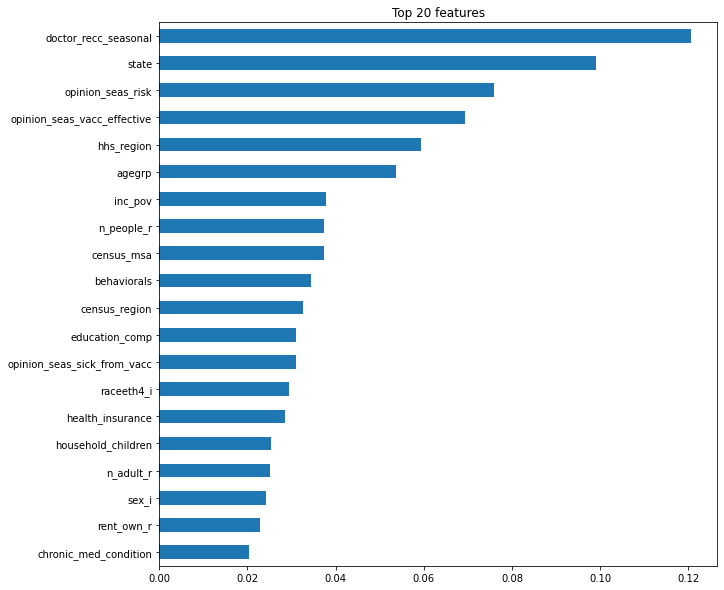

In [7]:
# 특성 중요도
rf = pipe.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

특성 중요도가 높게 나온 state는 유의해서 봐야 하겠습니다.
51개 카테고리로 구성되어 있는데 다른 특성과 비교하여 상대적으로 high-cardinarity 특성입니다.
트리 구성 중 분기에 이용될 확률이 높아 과적합 위험이 있습니다.

In [8]:
len(X_train['state'].value_counts())

51

### 2. Drop-Column Importance
이론적으로 가장 좋아 보이는 방법이지만, 매 특성을 drop한 후 fit을 다시 해야 하기 때문에 매우 느리다는 단점이 있습니다.

특성이 n개 존재할 때 n + 1 번 학습이 필요합니다.

In [9]:
column  = 'opinion_seas_risk'

# opinion_h1n1_risk 없이 fit
pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=100, random_state=2, n_jobs=-1)
)
pipe.fit(X_train.drop(columns=column), y_train)
score_without = pipe.score(X_val.drop(columns=column), y_val)
print(f'검증 정확도 ({column} 제외): {score_without}')

# opinion_h1n1_risk 포함 후 다시 학습
pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=100, random_state=2, n_jobs=-1)
)
pipe.fit(X_train, y_train)
score_with = pipe.score(X_val, y_val)
print(f'검증 정확도 ({column} 포함): {score_with}')

# opinion_h1n1_risk 포함 전 후 정확도 차이를 계산합니다
print(f'{column}의 Drop-Column 중요도: {score_with - score_without}')

검증 정확도 (opinion_seas_risk 제외): 0.733127742853754
검증 정확도 (opinion_seas_risk 포함): 0.7526983750444787
opinion_seas_risk의 Drop-Column 중요도: 0.019570632190724635


### 3. 순열중요도, (Permutation Importance, Mean Decrease Accuracy,MDA)
순열 중요도는 기본 특성 중요도와 Drop-column 중요도 중간에 위치하는 특징을 가진다고 볼 수 있습니다.

중요도 측정은 관심있는 특성에만 무작위로 노이즈를 주고 예측을 하였을 때 성능 평가지표(정확도, F1, $R^2$ 등)가 얼마나 감소하는지를 측정합니다.

Drop-column 중요도를 계산하기 위해 재학습을 해야 했다면, 순열중요도는 검증데이터에서 각 특성을 제거하지 않고 특성값에 무작위로 노이즈를 주어 기존 정보를 제거하여 특성이 기존에 하던 역할을 하지 못하게 하고 성능을 측정합니다. 이때 노이즈를 주는 가장 간단한 방법이 그 특성값들을 샘플들 내에서 섞는 것(shuffle, permutation) 입니다.

[The ELI5 library documentation explains, permutation importance](https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html)


### 순열중요도를 직접 계산해 봅시다

In [10]:
# 변경 할 특성을 선택합니다
feature = 'opinion_seas_risk'
X_val[feature].head()

11966     Somewhat Low
1211          Very Low
4407      Somewhat Low
1827     Somewhat High
23988              NaN
Name: opinion_seas_risk, dtype: object

In [11]:
# 특성의 분포를 확인합니다
X_val[feature].value_counts()

Somewhat Low     2300
Somewhat High    1875
Very Low         1505
Very High         780
Dont Know         175
Refused            11
Name: opinion_seas_risk, dtype: int64

In [12]:
# 특성의 값을 무작위로 섞습니다
X_val_permuted = X_val.copy()
X_val_permuted[feature] = np.random.RandomState(seed=7).permutation(X_val_permuted[feature])

In [13]:
# 특성 값의 순서가 뒤바뀐 것을 확인합니다
X_val_permuted[feature].head()

11966     Somewhat Low
1211     Somewhat High
4407     Somewhat High
1827               NaN
23988         Very Low
Name: opinion_seas_risk, dtype: object

In [14]:
# 카테고리들의 분포는 바뀌지는 않았음을 확인합니다
X_val_permuted[feature].value_counts()

Somewhat Low     2300
Somewhat High    1875
Very Low         1505
Very High         780
Dont Know         175
Refused            11
Name: opinion_seas_risk, dtype: int64

In [15]:
# 순열 중요도 값을 얻습니다. (재학습이 필요 없습니다!)
score_permuted = pipe.score(X_val_permuted, y_val)

print(f'검증 정확도 ({feature}): {score_with}')
print(f'검증 정확도 (permuted "{feature}"): {score_permuted}')
print(f'순열 중요도: {score_with - score_permuted}')

검증 정확도 (opinion_seas_risk): 0.7526983750444787
검증 정확도 (permuted "opinion_seas_risk"): 0.7205550942948642
순열 중요도: 0.03214328074961448


In [16]:
# doctor_recc_h1n1 에 대해서 순열 중요도를 계산해 봅시다
feature = 'doctor_recc_seasonal'
X_val_permuted = X_val.copy()
X_val_permuted[feature] = np.random.permutation(X_val_permuted[feature])
score_permuted = pipe.score(X_val_permuted, y_val)

print(f'검증 정확도 ({feature}): {score_with}')
print(f'검증 정확도 (permuted "{feature}"): {score_permuted}')
print(f'순열 중요도: {score_with - score_permuted}')

검증 정확도 (doctor_recc_seasonal): 0.7526983750444787
검증 정확도 (permuted "doctor_recc_seasonal"): 0.6780927529355948
순열 중요도: 0.07460562210888388


eli5 라이브러를 사용해서 순열 중요도를 계산해 보겠습니다.

eli5 에 관한 문서를 확인해 보세요:
- [eli5.sklearn.PermutationImportance](https://eli5.readthedocs.io/en/latest/autodocs/sklearn.html#eli5.sklearn.permutation_importance.PermutationImportance)
- [eli5.show_weights](https://eli5.readthedocs.io/en/latest/autodocs/eli5.html#eli5.show_weights)
- [scikit-learn user guide, `scoring` parameter](https://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules)

In [17]:
from sklearn.pipeline import Pipeline
# encoder, imputer를 preprocessing으로 묶었습니다. 후에 eli5 permutation 계산에 사용합니다
pipe = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer())),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=2, n_jobs=-1)) 
])

In [18]:
# pipeline 생성을 확인합니다.
pipe.named_steps

{'preprocessing': Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                 ('simpleimputer', SimpleImputer())]),
 'rf': RandomForestClassifier(n_jobs=-1, random_state=2)}

In [19]:
pipe.fit(X_train, y_train)
print('검증 정확도: ', pipe.score(X_val, y_val))

검증 정확도:  0.7526983750444787


In [22]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import eli5
from eli5.sklearn import PermutationImportance

# permuter 정의
permuter = PermutationImportance(
    pipe.named_steps['rf'], # model
    scoring='accuracy', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# permuter 계산은 preprocessing 된 X_val을 사용합니다.
X_val_transformed = pipe.named_steps['preprocessing'].transform(X_val)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(X_val_transformed, y_val);

In [23]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

n_adult_r                     -0.003511
hhs_region                    -0.003108
census_region                 -0.003084
behavioral_face_mask          -0.003060
sex_i                         -0.002942
state                         -0.002918
behavioral_wash_hands         -0.002657
n_people_r                    -0.002562
behavioral_large_gatherings   -0.002538
behavioral_antiviral_meds     -0.002420
behavioral_avoidance          -0.002159
behavioral_outside_home       -0.002064
behavioral_touch_face         -0.001755
chronic_med_condition         -0.001613
census_msa                    -0.001542
behaviorals                   -0.001471
child_under_6_months          -0.001400
marital                       -0.001328
rent_own_r                    -0.000712
inc_pov                       -0.000474
raceeth4_i                    -0.000213
household_children            -0.000119
education_comp                 0.001234
health_insurance               0.002775
health_worker                  0.003060


In [24]:
# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

Weight,Feature
0.0714 ± 0.0047,doctor_recc_seasonal
0.0438 ± 0.0034,opinion_seas_vacc_effective
0.0410 ± 0.0032,opinion_seas_risk
0.0077 ± 0.0028,agegrp
0.0048 ± 0.0019,opinion_seas_sick_from_vacc
0.0031 ± 0.0026,health_worker
0.0028 ± 0.0020,health_insurance
0.0012 ± 0.0043,education_comp
-0.0001 ± 0.0025,household_children
-0.0002 ± 0.0028,raceeth4_i


### 중요도를 이용하여 특성을 선택(Feature selection)해 봅시다.

중요도가 -인 특성을 제외해도 성능은 거의 영향이 없으며, 모델학습 속도는 개선됩니다.

In [25]:
print('특성 삭제 전:', X_train.shape, X_val.shape)

특성 삭제 전: (33723, 30) (8431, 30)


In [26]:
minimum_importance = 0.001
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train_selected = X_train[features]
X_val_selected = X_val[features]

In [27]:
print('특성 삭제 후:', X_train_selected.shape, X_val_selected.shape)

특성 삭제 후: (33723, 8) (8431, 8)


In [28]:
# pipeline 다시 정의
pipe = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer())),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=2, n_jobs=-1)) 
], verbose=1)

pipe.fit(X_train_selected, y_train);

[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.1s
[Pipeline] ................ (step 2 of 2) Processing rf, total=   1.8s


In [29]:
print('검증 정확도: ', pipe.score(X_val_selected, y_val))

검증 정확도:  0.7513936662317637


In [30]:
# 순열 중요도의 평균 감소값과 그 표준편차의 차가 양수인 특징들을 확인할 수 있습니다.
permuter.feature_importances_ - permuter.feature_importances_std_ > 0

array([False, False, False, False, False, False, False,  True, False,
       False,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

## Boosting(xgboost for gradient boosting)를 사용해 봅시다

#### 분류문제를 풀기 위해서는 트리 앙상블 모델을 많이 사용합니다.
- 트리 앙상블은 랜덤포레스트나 **그래디언트 부스팅** 모델을 이야기 하며 여러 문제에서 좋은 성능을 보이는 것을 확인하였습니다.
- 트리모델은 non-linear, non-monotonic 관계, 특성간 상호작용이 존재하는 데이터 학습에 적용하기 좋습니다.
- 한 트리를 깊게 학습시키면 과적합을 일으키기 쉽기 때문에. 배깅(Bagging, 랜덤포레스트)이나 **부스팅(Boosting)** 앙상블 모델을 사용해 과적합을 피합니다.
- 랜덤포레스트의 장점은 **하이퍼파라미터에 상대적으로 덜 민감한** 것인데, 그래디언트 부스팅의 경우 하이퍼파라미터 셋팅에 따라 랜덤포레스트 보다 **더 좋은 예측 성능**을 보여줄 수도 있습니다.

#### 부스팅과 배깅의 차이점은?

랜덤포레스트나 그래디언트 부스팅은 모두 트리 앙상블 모델이지만 트리를 만드는 방법에 차이가 있습니다.

가장 큰 차이는, 랜덤포레스트의 경우 각 트리를 독립적으로 만들지만 **부스팅은 만들어지는 트리가 이전에 만들어진 트리에 영향을 받는다**는 것입니다.

부스팅 알고리즘 중 AdaBoost는 각 트리(약한 학습기들, weak learners)가 만들어질 때 잘못 분류되는 관측치에 가중치를 줍니다.

그리고 다음 트리가 만들어질 때 이전에 잘못 분류된 관측치가 더 많이 샘플링되게 하여 그 관측치를 분류하는데 더 초점을 맞춥니다.


#### AdaBoost의 알고리즘 예시 입니다.

##### Step 0. 모든 관측치에 대해 가중치를 동일하게 설정 합니다.

##### Step 1. 관측치를 복원추출 하여 약한 학습기 Dn을 학습하고 +, - 분류 합니다.

##### Step 2. 잘못 분류된 관측치에 가중치를 부여해 다음 과정에서 샘플링이 잘되도록 합니다.

##### Step 3. Step 1~2 과정을 n회 반복(n = 3) 합니다.

##### Step 4. 분류기들(D1, D2, D3)을 결합하여 최종 예측을 수행합니다.

<img src="https://i.imgur.com/XzrlIjT.png" width="500"  />


알고리즘을 다시 살펴 볼까요?

<img src="https://i.imgur.com/UFtdSCR.png" width="700" />


최종 학습기 **H(x)** 는 **약한 학습기들**($h_t$)의 **가중($\alpha$)합**으로 만들어집니다.
여기서 $\alpha_t$ 가 크면 $e_t$가 작다는 것으로 분류기 $h_t$ 성능이 좋다는 것이고
여기서 $\alpha_t$ 가 작으면 $e_t$가 크다는 것으로 분류기 $h_t$ 성능이 안좋다는 뜻입니다.



#### 그래디언트 부스팅
그래디언트 부스팅은 회귀와 분류문제에 모두 사용할 수 있습니다. 아래 그림은 직관적인 이해를 위해 회귀문제에 적용하는 그래디언트 부스팅 학습 방법을 보여줍니다.
<img src="https://i.imgur.com/OhKsBke.png" />

그래디언트 부스팅은 AdaBoost와 유사하지만 비용함수(Loss function)을 최적화하는 방법에 있어서 차이가 있습니다. 그래디언트 부스팅에서는 샘플의 가중치를 조정하는 대신 잔차(residual)을 학습하도록 합니다. 이것은 잔차가 더 큰 데이터를 더 학습하도록 만드는 효과가 있습니다.



sklearn 외에 부스팅이 구현된 여러가지 라이브러리를 사용할 수 있습니다:

#### Python libraries for Gradient Boosting
- [scikit-learn Gradient Tree Boosting](https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting) — 상대적으로 속도가 느릴 수 있습니다.
  - Anaconda: already installed
  - Google Colab: already installed
- [xgboost](https://xgboost.readthedocs.io/en/latest/) — 결측값을 수용하며, [monotonic constraints](https://xiaoxiaowang87.github.io/monotonicity_constraint/)를 강제할 수 있습니다.
  - Anaconda, Mac/Linux: `conda install -c conda-forge xgboost`
  - Windows: `conda install -c anaconda py-xgboost`
  - Google Colab: already installed
- [LightGBM](https://lightgbm.readthedocs.io/en/latest/) — 결측값을 수용하며, [monotonic constraints](https://blog.datadive.net/monotonicity-constraints-in-machine-learning/)를 강제할 수 있습니다.
  - Anaconda: `conda install -c conda-forge lightgbm`
  - Google Colab: already installed
- [CatBoost](https://catboost.ai/) — 결측값을 수용하며, [categorical features](https://catboost.ai/docs/concepts/algorithm-main-stages_cat-to-numberic.html)를 전처리 없이 사용할 수 있습니다.
  - Anaconda: `conda install -c conda-forge catboost`
  - Google Colab: `pip install catboost`

##### 참고: monotonic constraints

In [31]:
# monotonic constraints 효과, 단조증가해야 하는 특성이 오류로 비단조 증가할때 변수마다 적용 가능합니다.
from IPython.display import HTML, display
display(HTML('<table><tr><td><img src="https://xiaoxiaowang87.github.io/images/2016-11-20-monotonicity_constraint/no_constraint_one_feature.png" width="300" /></td><td><img src="https://xiaoxiaowang87.github.io/images/2016-11-20-monotonicity_constraint/w_constraint_one_feature.png" width="300" /></td></tr></table>'))


,


이번에는 sklearn 이 아닌 다른 라이브러리의 ML 모델을 사용해 봅시다. xgboost는, sklearn과 사용방법이 매우 유사하니 걱정하실 필요 없습니다.

In [32]:
from xgboost import XGBClassifier

pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    XGBClassifier(n_estimators=200
                  , random_state=2
                  , n_jobs=-1
                  , max_depth=7
                  , learning_rate=0.2
                 )
)

pipe.fit(X_train, y_train);

xgboost 는 랜덤포레스트보다 하이퍼파라미터 셋팅에 민감합니다

In [33]:
from sklearn.metrics import accuracy_score
y_pred = pipe.predict(X_val)
print('검증 정확도: ', accuracy_score(y_val, y_pred))

print(classification_report(y_pred, y_val))

검증 정확도:  0.7601707982445736
              precision    recall  f1-score   support

           0       0.79      0.77      0.78      4724
           1       0.72      0.74      0.73      3707

    accuracy                           0.76      8431
   macro avg       0.76      0.76      0.76      8431
weighted avg       0.76      0.76      0.76      8431



#### Early Stopping을 사용하여 과적합을 피합니다

왜 `n_estimators` 최적화를 위해 GridSearchCV나 반복문 대신 early stopping을 사용할까요?

`n_iterations` 가 반복수라 할때, early stopping을 사용하면 우리는 `n_iterations` 만큼의 트리를 학습하면 됩니다.

하지만 GridSearchCV나 반복문을 사용하면 무려 `sum(range(1,n_rounds+1))` 트리를 학습해야 합니다!
거기에 `max_depth`, `learning_rate` 등등 파라미터 값에 따라 더 돌려야 합니다.

early stopping을 잘 활용하는게 훨씬 효과적이겠지요.

- [Avoid Overfitting By Early Stopping With XGBoost In Python](https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/)


#### 타겟 비율이 균형이 안맞을 때는 클래스에 weight를 주기 위해 ratio를 계산합니다.

In [34]:
vc = y_train.value_counts().tolist()
vc

[18431, 15292]

In [35]:
# sum(negative instances) / sum(positive instances)
ratio = float(vc[0]/vc[1])
ratio

1.205270729793356

In [36]:
encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train) # 학습데이터
X_val_encoded = encoder.transform(X_val) # 검증데이터

model = XGBClassifier(
    n_estimators=1000,  # <= 1000 트리로 설정했지만, early stopping 에 따라 조절됩니다.
    max_depth=7,        # default=3, high cardinality 특성을 위해 기본보다 높여 보았습니다.
    learning_rate=0.2,
#     scale_pos_weight=ratio, # imbalance 데이터 일 경우 비율을 적용합니다.
    n_jobs=-1
)

eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

model.fit(X_train_encoded, y_train, 
          eval_set=eval_set,
          eval_metric='error', # #(wrong cases)/#(all cases)
          early_stopping_rounds=50
         ) # 50 rounds 동안 스코어의 개선이 없으면 멈춤

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-error:0.23978	validation_1-error:0.24801
[1]	validation_0-error:0.23509	validation_1-error:0.24564
[2]	validation_0-error:0.22940	validation_1-error:0.24268
[3]	validation_0-error:0.22830	validation_1-error:0.24173
[4]	validation_0-error:0.22575	validation_1-error:0.23900
[5]	validation_0-error:0.22409	validation_1-error:0.23817
[6]	validation_0-error:0.22258	validation_1-error:0.23663
[7]	validation_0-error:0.22098	validation_1-error:0.23627
[8]	validation_0-error:0.22089	validation_1-error:0.23734
[9]	validation_0-error:0.21893	validation_1-error:0.23627
[10]	validation_0-error:0.21691	validation_1-error:0.23485
[11]	validation_0-error:0.21626	validation_1-error:0.23508
[12]	validation_0-error:0.21419	validation_1-error:0.23437
[13]	validation_0-error:0.21261	validation_1-error:0.23331
[14]	validation_0-error:0.21101	validation_1-error:0.23354
[15]	validation_0-error:0.21009	validation_1-error:0.23212
[16]	validation_0-error:0.20888	validation_1-error:0.23224
[17]	va

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

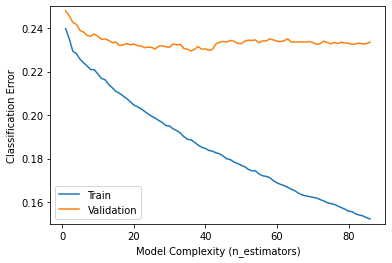

In [37]:
results = model.evals_result()
train_error = results['validation_0']['error']
val_error = results['validation_1']['error']

epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
plt.ylim((0.15, 0.25)) # Zoom in
plt.legend();

In [38]:
print('검증 정확도', model.score(X_val_encoded, y_val))

print(classification_report(y_val, model.predict(X_val_encoded)))


검증 정확도 0.7704898588542285
              precision    recall  f1-score   support

           0       0.78      0.81      0.79      4608
           1       0.76      0.73      0.74      3823

    accuracy                           0.77      8431
   macro avg       0.77      0.77      0.77      8431
weighted avg       0.77      0.77      0.77      8431



### 하이퍼파라미터 튜닝
#### Random Forest
- max_depth (높은값에서 감소시키며 튜닝, 너무 깊어지면 과적합)
- n_estimators (적을경우 과소적합, 높을경우 긴 학습시간)
- min_samples_leaf (과적합일경우 높임)
- max_features (줄일 수록 다양한 트리생성, 높이면 같은 특성을 사용하는 트리가 많아져 다양성이 감소)
- class_weight (imbalanced 클래스인 경우 시도)

#### XGBoost
- learning_rate (높을경우 과적합 위험이 있습니다)
- max_depth (낮은값에서 증가시키며 튜닝, 너무 깊어지면 과적합위험, -1 설정시 제한 없이 분기, 특성이 많을 수록 깊게 설정)
- n_estimators (너무 크게 주면 긴 학습시간, early_stopping_rounds와 같이 사용)
- scale_pos_weight (imbalanced 문제인 경우 적용시도)



보다 자세한 내용은 다음을 참고하세요
- [Notes on Parameter Tuning](https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html)

## 참고자료

- [Olson 2017](https://arxiv.org/abs/1708.05070)

- [Feature Importance in Decision Trees](https://sefiks.com/2020/04/06/feature-importance-in-decision-trees/)

- Permutation Importance
    - [Kaggle: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)
    - [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)
    - [Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
    - [Permutation Importance vs Random Forest Feature Importance (MDI)](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html) 
    - [Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)
    - [eli5.sklearn.PermutationImportance](https://eli5.readthedocs.io/en/latest/autodocs/sklearn.html#eli5.sklearn.permutation_importance.PermutationImportance)
    - [eli5.show_weights](https://eli5.readthedocs.io/en/latest/autodocs/eli5.html#eli5.show_weights)
    - [scikit-learn user guide, `scoring` parameter](https://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules)
    
- Boosting
    - [Understanding AdaBoost](https://towardsdatascience.com/understanding-adaboost-2f94f22d5bfe)
    - [Study of AdaBoost and Gradient Boosting Algorithms for Predictive Analytics](https://link.springer.com/chapter/10.1007/978-981-15-0633-8_22)
    - [Gradient Boosting, DataCamp](https://campus.datacamp.com/courses/machine-learning-with-tree-based-models-in-python/boosting?ex=5)
    - [Gradient Boost Part 2: Regression Details](https://youtu.be/2xudPOBz-vs)
    - [Gradient Boost Part 3: Classification](https://youtu.be/jxuNLH5dXCs)
    - [Avoid Overfitting By Early Stopping With XGBoost In Python](https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/)
    - [Notes on parameter tuning](https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html)
    - [Parameters documentation](https://xgboost.readthedocs.io/en/latest/parameter.html)



# Exercise

## sklearn breast_cancer dataset 으로 Xgboost 를 연습해보자

- **breast cancer 데이터를 Xgboost로 학습하고 f1 score를 제출하세요.(test 데이터에서 0.95이상)**

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer 

cancer_dataset = load_breast_cancer()

features = cancer_dataset.data
target = cancer_dataset.target
df = pd.DataFrame(data=features, columns=cancer_dataset.feature_names)
df['target'] = target

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=2)
print(X_train.shape, X_test.shape)

(455, 30) (114, 30)


In [40]:
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer

pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    XGBClassifier(n_estimators=200
                  , random_state=2
                  , n_jobs=-1
                  , max_depth=7
                  , learning_rate=0.2
                 )
)

pipe.fit(X_train, y_train);

In [41]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

y_pred = pipe.predict(X_test)
print('검증 정확도: ', f1_score(y_test, y_pred))

print(classification_report(y_pred, y_test))

검증 정확도:  0.9635036496350365
              precision    recall  f1-score   support

           0       0.96      0.93      0.95        46
           1       0.96      0.97      0.96        68

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



### 3) Permutation importances를 계산하고 다른 중요도 결과와 비교해 보세요

- **breast cancer 데이터를 사용해 만든 모델의 Permutation importances를 계산하고 가장 높은 값을 가지는 특성의 이름을 제출하세요.**
    - eli5 PermutationImportance 사용
    - scoring = 'accuracy'
    - n_iter = 5
    - random_state = 2

In [42]:
from sklearn.pipeline import Pipeline
import eli5
from eli5.sklearn import PermutationImportance
import warnings
import numpy as np

warnings.simplefilter(action='ignore', category=FutureWarning)
pipe = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer())),
    ('xg', XGBClassifier(n_estimators=200
                  , random_state=2
                  , n_jobs=-1
                  , max_depth=7
                  , learning_rate=0.2
                 )) 
])


pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)


0.956140350877193

In [44]:
permuter = PermutationImportance(
    pipe.named_steps['xg'], # model
    scoring='accuracy', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

X_test_transformed = pipe.named_steps['preprocessing'].transform(X_test)

permuter.fit(X_test_transformed, y_test);

In [45]:
feature_names = df.columns[:-1]
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

mean smoothness            0.035088
worst texture              0.035088
compactness error          0.021053
mean concave points        0.019298
worst perimeter            0.019298
worst smoothness           0.017544
worst area                 0.017544
texture error              0.017544
worst concave points       0.015789
perimeter error            0.015789
symmetry error             0.014035
worst symmetry             0.012281
area error                 0.012281
worst radius               0.012281
mean symmetry              0.010526
worst fractal dimension    0.008772
worst concavity            0.008772
mean texture               0.005263
radius error               0.005263
mean compactness           0.005263
fractal dimension error    0.003509
concavity error            0.000000
concave points error       0.000000
smoothness error           0.000000
mean fractal dimension     0.000000
mean concavity             0.000000
worst compactness          0.000000
mean area                  0

In [46]:
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names.to_list() # list 형식으로 넣어야 합니다
)

Weight,Feature
0.0351 ± 0.0222,mean smoothness
0.0351 ± 0.0111,worst texture
0.0211 ± 0.0140,compactness error
0.0193 ± 0.0131,mean concave points
0.0193 ± 0.0131,worst perimeter
0.0175 ± 0.0111,texture error
0.0175 ± 0.0111,worst smoothness
0.0175 ± 0.0400,worst area
0.0158 ± 0.0233,worst concave points
0.0158 ± 0.0131,perimeter error
